In [1]:
using StatsBase,StatsFuns,Random,Distributions,GLM
using CSV,DataFrames,LinearAlgebra,Optim
using RCall
# import Plots,PlotlyJS,ORCA
using JuMP,Ipopt,ForwardDiff#Test
# define macro for easy access
DF = DataFrames;
MC = MathConstants;

# ECO 542 HW 2 - Auctions

## 1. FPSB auctions


1. Estimate $F_U(u_1,u_2,u_3)$ for each $u_i$ corresponding to the marginal 25th or 75th percentile.

In [2]:
## load data
d1 = CSV.read("FPSB_data.csv");
d1.m1 = max.(d1.bid2,d1.bid3);
d1.m2 = max.(d1.bid1,d1.bid3);
d1.m3 = max.(d1.bid1,d1.bid2);
#first(d1,5)
describe(d1)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Nothing,Union…,DataType
1,bid1,139.37,60.4839,140.776,181.826,,0,Float64
2,bid2,139.622,69.3219,141.12,182.411,,0,Float64
3,bid3,153.136,97.7667,156.928,164.104,,0,Float64
4,m1,157.116,106.77,159.055,182.411,,,Float64
5,m2,157.072,117.863,158.977,181.826,,,Float64
6,m3,150.986,105.6,152.018,182.411,,,Float64


In [3]:
## extract 25th and 75th percentiles of bids from the marginal distribution for each bidder
bQuantiles = [quantile(d1[:,i],j;sorted=false) for i=1:3, j in [0.25,0.75]]

3×2 Array{Float64,2}:
 125.875  154.847
 125.256  154.008
 148.392  161.59 

In [4]:
[cor(d1[:,i],d1[:,j]) for i=1:3,j=1:3]

3×3 Array{Float64,2}:
  1.0          0.0182918  -0.00599598
  0.0182918    1.0        -0.0112422 
 -0.00599598  -0.0112422   1.0       

The bidders do not appear to be ex ante symmetric, since bidder 3's 25th percentile of bids (hence valuations) is much higher than bidder 1's and 2's. However, the correlation matrix above suggests that the players' valuations are pairwise uncorrelated, i.e. that we cannot reject independence.

In [5]:
## extract the 25th percentile of all 3 first
bL = bQuantiles[:,1]
b227List = [[i==j ? bQuantiles[i,2] : bQuantiles[i,1] for i=1:3] for j=1:3]
b277List = [[i==j ? bQuantiles[i,1] : bQuantiles[i,2] for i=1:3] for j=1:3]
bH = bQuantiles[:,2]

function empCDF(x::Array{Float64,1})
    lowerThanMatrix = hcat(d1.bid1 .<= x[1],d1.bid2 .<= x[2],d1.bid3 .<= x[3])
    lowerThanVector = [((lowerThanMatrix[i,1] == false || 
                lowerThanMatrix[i,2] == false || 
                lowerThanMatrix[i,3] == false) ? 0 : 1) for i=1:1000]
    sum(lowerThanVector)/1000
end

@show empCDF(bL);
@show [empCDF(bVal) for bVal in b227List];
@show [empCDF(bVal) for bVal in b277List];
@show empCDF(bH);

## get reference values
@show 0.25^3
@show 0.25^2*0.75
@show 0.25*0.75^2
@show 0.75^3

empCDF(bL) = 0.013
[empCDF(bVal) for bVal = b227List] = [0.034, 0.05, 0.051]
[empCDF(bVal) for bVal = b277List] = [0.144, 0.139, 0.14]
empCDF(bH) = 0.429
0.25 ^ 3 = 0.015625
0.25 ^ 2 * 0.75 = 0.046875
0.25 * 0.75 ^ 2 = 0.140625
0.75 ^ 3 = 0.421875


0.421875

The results from our empirical CDF computations corroborate our above findings: independence appears to hold, since the symmetric empirical moments (all 25 or all 75) match the theoretical ones. Yet the empirical CDF when the quantiles are (0.75,0.25,0.25) is 0.034, which is quite far away from the theoretical benchmark of 0.0468. Hence symmetry fails.

2. Nonparametrically estimate the underlying distribution of valuations, assuming affiliated private values and no reserve price.

In [6]:
## sample size, Gaussian kernel and Silverman's rule of thumb bandwidth
T = size(d1.bid1,1);
kernN(u) = pdf.(Normal(),u);
h = [1.06*std(d1[:,i])*T^(-1/5) for i=1:3];

## construct indicators and kernel weights
function G_MB(b::Number,i::Number)
    G = dot(kernN((b .- d1[:,i])/h[i]),(d1[:,i+3] .<= b)*1.0)
    (1/(T*h[i]))*G
end

function g_MB(b::Number,i::Number)
    g = dot(kernN((b .- d1[:,i])/h[i]),kernN((b .- d1[:,i+3])/h[i]))
    (1/(T*h[i]^2))*g
end

function estU(i::Number)
    d1[:,i] .+ (G_MB.(d1[:,i],i)./g_MB.(d1[:,i],i))
end

estU (generic function with 1 method)

In [7]:
for i=1:3
    d1[:,i+6] = estU(i)
end

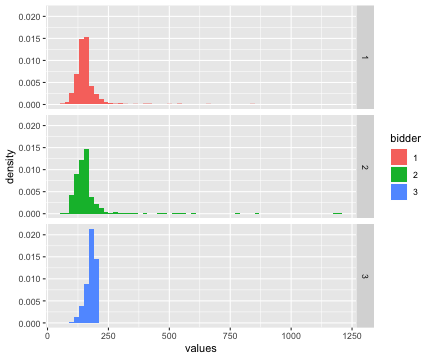

RObject{VecSxp}


In [8]:
u1 = d1[:,7]
u2 = d1[:,8]
u3 = d1[:,9]
@rput u1
@rput u2
@rput u3
R"""library(ggplot2);
bidder <- c(rep("1",1000),rep("2",1000),rep("3",1000))
values <- c(u1,u2,u3)
dfECDF <- data.frame(bidder=bidder,values=values)
ggplot(dfECDF,aes(x=values)) + geom_histogram(aes(y=..density..,fill=bidder),binwidth=20) + facet_grid(bidder~.)
"""

3. Nonparametrically estimate the underlying distribution of valuations, assuming independent private values and no reserve price.

## 2. Ascending auctions

In [10]:
d2 = CSV.read("Ascending_data.csv");
#first(d2,5)
describe(d2)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Nothing,Int64,DataType
1,transactionPrice,191.491,138.11,192.065,250.55,,0,Float64
2,winner,2.503,1,3.0,4,,0,Int64
3,N,4.0,4,4.0,4,,0,Int64


1. Nonparametrically estimate the underlying distribution of valuations from data on the number of bidders and the prices paid, assuming SIPV, no reserve price, and a button auction (Milgrom and Weber 1982).

The goal is to solve for $F_U(u)$, where $F_U(u) = \phi(F_U^{(i:n)}(u);i,n)$, over $i=1,2,3,4$.
For $i=1$, the fixed point problem reduces to
$$
\hat G_B^{(n-1:n)}(u) = 1 - (1-\phi(u))^n \Rightarrow \phi(u) = 1 - [1 - \hat G_B^{(n-1:n)}(u)]^{1/n}.
$$

In [39]:
## compute kernel estimator
gridU = 135:0.5:255
G_B1(u::Number) = mean((d2.transactionPrice .<= u) .* 1.0)

## fix i=1 for now
phi1(u::Number) = 1 - (1-G_B1(u))^(1/4)
grid1 = [phi1(u) for u in gridU]

241-element Array{Float64,1}:
 0.0                   
 0.0                   
 0.0                   
 0.0                   
 0.0                   
 0.0                   
 0.0                   
 0.00025009380472507114
 0.0005003754381024406 
 0.0007508452296147716 
 0.0007508452296147716 
 0.0007508452296147716 
 0.0012523506095245551 
 ⋮                     
 0.8221720589961077    
 0.8221720589961077    
 0.8221720589961077    
 1.0                   
 1.0                   
 1.0                   
 1.0                   
 1.0                   
 1.0                   
 1.0                   
 1.0                   
 1.0                   

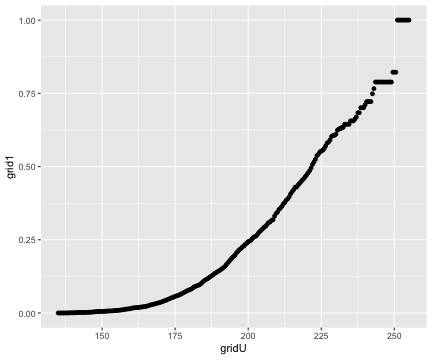

RObject{VecSxp}


In [40]:
## this is a plot of the CDF of the valuations

@rput gridU
@rput grid1
R"""
library(ggplot2)
qplot(gridU,grid1)
"""

2. Estimate bounds on the CDF (Haile and Tamer 2003), assuming a minimum bid increment of 1.

For the upper bound $F^+$, we have $i=3$. The fixed point problem is implicitly solved by
$$
\hat G_B^{(3:4)}(u) = 4\phi(u)^3 - 3\phi(u)^4.
$$

In [55]:
## only given (n-1:n) in the data, so that's the only lower bound we have
G_B2(u::Number) = mean((d2.transactionPrice .<= u) .* 1.0)
## I don't know the formula for G_Delta, since I do not observe b^(n:n). Here's a guess
G_Delta(u::Number) = mean(((d2.transactionPrice .+ 1) .<= u) .* 1.0)

0.577

In [145]:
## compute the appropriate ϕ values for upper bound

gridUB = Float64[]
for u in gridU
    y = G_B2(u)
    m = Model(with_optimizer(Ipopt.Optimizer,print_level=0));
    @variable(m,0 <= x <= 1)
    @NLobjective(m, Min, (y-4*x^3-3*x^4)^2)
    optimize!(m)
    push!(gridUB,value(x))
end

## similarly for lower bound?
gridLB = Float64[]
for u in gridU
    y = G_Delta(u)
    m = Model(with_optimizer(Ipopt.Optimizer,print_level=0));
    @variable(m,0 <= x <= 1)
    @NLobjective(m, Min, (y-4*x^3-3*x^4)^2)
    optimize!(m)
    push!(gridLB,value(x))
end

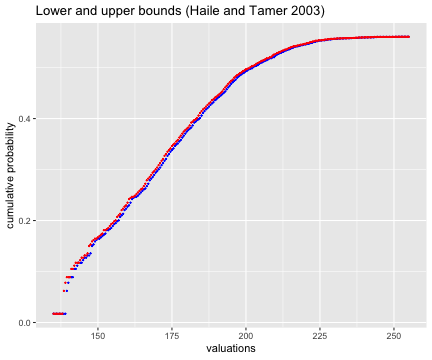

RObject{VecSxp}


In [174]:
grid2Mat = hcat([i for i in 135:0.5:255],gridLB,gridUB)
@rput gridU
@rput gridLB
@rput gridUB
R"""
library(broom,ggplot2)
df <- data.frame(gridU,gridLB,gridUB)
names(df) <- c("U","LB","UB")
plt <- ggplot(df,aes(x=U,y=LB)) +
    geom_point(color="blue",size=0.25) +
    geom_point(aes(x=U,y=UB),color="red",size=0.25) +
    labs(x="valuations",y="cumulative probability",
        title="Lower and upper bounds (Haile and Tamer 2003)")
"""